# Sentiment Analysis with VADER and NLP Modeling
by: Caroline Schmitt and Heather Robbins

#### VADER (Valence Aware Dictionary and sEntiment Reasoner):
is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

<img src="https://media.giphy.com/media/3ohuPsd2QJlKWmhgSk/giphy.gif" style="float: center; margin: 20px; height: 300px">

## Advantages of using VADER

VADER has a lot of advantages over traditional methods of Sentiment Analysis, including:

- It works exceedingly well on social media type text, yet readily generalizes to multiple domains
- It is fast enough to be used online with streaming data, and
- It does not severely suffer from a speed-performance tradeoff.
- It takes punctuation and capitalization into account
- It can interpret emojis 

In [168]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

## Load in the text data:

In [169]:
tweets = pd.read_csv('disaster_train.csv')
tweets.head(2)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [170]:
#get rid of unnecessary columns

tweets = tweets[['text', 'target']]

In [171]:
tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Format tweets for VADER:

The `SentimentIntensityAnalyzer` will expect a list of strings.

In [172]:
#convert to a list of strings:

corpus = list(tweets['text'])
corpus[1]

'Forest fire near La Ronge Sask. Canada'

## Instantiate `SentimentIntensityAnalyzer` and test it on the first tweet:

In [173]:
#instantiate SIA
sia = SentimentIntensityAnalyzer()

#Get polarity scores for the first tweet
sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.2732}

- The 'compound' score is computed by summing the scores of each word and then is normalized to be between -1 (most extreme negative) and +1 (most extreme positive). 
- This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 
- Calling it a 'normalized, weighted composite score' is accurate.

## Dataframe of sentiment analyses:

In [174]:
tweets.head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [175]:
#create dataframe that contains text and the polarity scores for each tweet

dicts = []    

for tweet in corpus:
    scores = sia.polarity_scores(tweet)
    scores['text'] = tweet
    dicts.append(scores)

df = pd.DataFrame(dicts)
df.head()

,compound,neg,neu,pos,text
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California"
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


## Add original author:

In [176]:
df['target'] = tweets['target'].values
df.head(5)

,compound,neg,neu,pos,text,target
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada,1
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California",1
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Investigating polarities:

#### Looking at positive and negative text for Real Disasters

In [177]:
df1 = df[df['target'] == 1]

In [178]:
df1.sort_values(by='pos', ascending=False).head()

,compound,neg,neu,pos,text,target
5887,0.6449,0.0,0.319,0.681,SANDSTORM!!! WOO HOO!!,1
1567,0.8834,0.0,0.347,0.653,ok peace I hope I fall off a cliff along with my dignity,1
2457,0.9356,0.0,0.425,0.575,@Raishimi33 :) well I think that sounds like a fine plan where little derailment is possible so I applaud you :),1
625,0.8316,0.0,0.443,0.557,CDC has a pretty cool list of all bioterrorism agents :3,1
3488,0.7269,0.0,0.450,0.550,@lordRsBiscuits That's always good for a pretty explosion.,1


In [179]:
df1.sort_values(by='neg', ascending=False).head()

,compound,neg,neu,pos,text,target
3688,-0.6705,0.818,0.182,0.0,Fatality https://t.co/GF5qjGoyCi,1
4504,-0.6062,0.798,0.202,0.0,hurricane?? sick!,1
7195,-0.8436,0.752,0.248,0.0,@abcnews A nuclear bomb is a terrible weapon!!,1
6451,-0.9022,0.735,0.265,0.0,Kurd Suicide Attack Kills 2 Turkish Soldiers http://t.co/GHGHQm9e6d,1
2768,-0.9169,0.683,0.317,0.0,#Thorium Radioactive Weapons. Scandals murders and environmental devastation: - VIDEO http://t.co/mly7sDN6eV,1


#### Looking at positive and negative text for Fake Disasters

In [180]:
df0 = df[df['target'] == 0]

In [181]:
df0.sort_values(by='pos', ascending = False).head(10)

,compound,neg,neu,pos,text,target
4758,0.8442,0.0,0.099,0.901,@Benji_Devos thanks thanks :3,0
5382,0.7906,0.0,0.125,0.875,@panic awesome thanks.,0
6140,0.9300,0.0,0.127,0.873,Super sweet and beautiful :) https://t.co/TUi9uwBvVp,0
433,0.6408,0.0,0.191,0.809,@local_arsonist LMFAO,0
22,0.6369,0.0,0.192,0.808,Love skiing,0
16,0.6369,0.0,0.192,0.808,I love fruits,0
645,0.7845,0.0,0.225,0.775,@Shayoly yes I love it,0
1723,0.7650,0.0,0.233,0.767,We're happily collided :),0
28,0.4588,0.0,0.250,0.750,Cooool :),0
6965,0.7147,0.0,0.251,0.749,@tsunami_esh ESH PLEASE OKAY!,0


In [182]:
df0.sort_values(by='neg', ascending = False).head(10)

,compound,neg,neu,pos,text,target
3670,-0.6705,1.000,0.000,0.0,fatality,0
6015,-0.2960,1.000,0.000,0.0,* Screams *,0
5184,-0.4767,1.000,0.000,0.0,Obliterated,0
3667,-0.6996,1.000,0.000,0.0,Fatality!,0
1882,-0.4215,1.000,0.000,0.0,Crushed,0
7472,-0.9883,1.000,0.000,0.0,wreck? wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck?,0
6372,-0.8271,0.885,0.115,0.0,she's a suicide bomb,0
7185,-0.6908,0.851,0.149,0.0,FUCK NUCLEAR WEAPON,0
900,-0.6808,0.848,0.152,0.0,Damn bloody hot,0
3696,-0.7550,0.845,0.155,0.0,Fatality ????,0


# Visualizing sentiments

Let's do some EDA on the sentiments.

### Plot the average positivity, negativity and compound scores for Real vs Not Real Disasters:

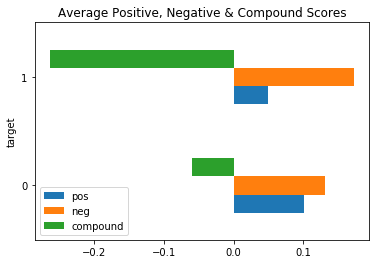

In [183]:
df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');

# 1 is real disaster and 0 is fake disaster

# Modeling-Prep

In [184]:
df.head()

,compound,neg,neu,pos,text,target
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada,1
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California",1
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#### Use Regex to take out hyperlinks, etc

In [187]:
df['text'] = df['text'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('#\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [188]:
#split text data intro training and test sets

X = df[['text', 'compound', 'neg', 'neu', 'pos']]
y = df['target']

In [189]:
X.shape

(7613, 5)

In [190]:
#check for balanced classes 

y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11, stratify = y)

In [192]:
# get baseline accuracy for training & test set

y_train.mean(), y_test.mean()

(0.4297208538587849, 0.4294156270518713)

### CountVectorizer

In [205]:
cv = CountVectorizer(stop_words = 'english', max_features = 3000)

X_train_cv = cv.fit_transform(X_train['text'])
X_test_cv = cv.transform(X_test['text'])

#### Create new dataframes for training and test text

In [206]:
df_X_train = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [209]:
df_X_test = pd.DataFrame(X_test_cv.todense(), columns = cv.get_feature_names())

#### Reset indices in all dataframes

In [210]:
df_X_train.reset_index(drop=True, inplace=True)

In [214]:
X_train.reset_index(drop=True, inplace=True)

In [215]:
df_X_test.reset_index(drop=True, inplace = True)

In [216]:
X_test.reset_index(drop=True, inplace=True)

#### Add sentiment scores back to text data. merge on index, drop 'text' column 

In [217]:
combined_X_train = pd.concat([df_X_train, X_train], axis =1)
combined_X_train.head(1)

,00,000,01,02,03,04,05,06,07,08,...,ûªve,ûï,ûïwhen,ûò,ûó,text,compound,neg,neu,pos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,@MeetKakarotto 'Don't bother while you were offline I managed to evacuate everyone out of here including Hinata so so go ahead and cause--,0.1371,0.064,0.85,0.087


In [218]:
combined_X_test = pd.concat([df_X_test, X_test], axis = 1)

#### Drop Text Column

In [219]:
combined_X_train.drop(columns = 'text', inplace=True)

In [220]:
combined_X_test.drop(columns = 'text', inplace = True)

#### Checking all my data dimensions

In [221]:
combined_X_train.shape, combined_X_test.shape

((6090, 3003), (1523, 3003))

In [222]:
y_train.shape, y_test.shape

((6090,), (1523,))

### Modeling Time!

In [223]:
#instantiate model

In [224]:
dt = DecisionTreeClassifier()
dt.fit(combined_X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [100]:
dt.score(combined_X_train, y_train), dt.score(combined_X_test, y_test)

(0.9860426929392446, 0.7360472751149048)

### We can try hyperparameter tuning with GridSearchCV:

In [101]:
params = [{'max_depth': [15, 25, 50, 100],   #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves     
            'max_features': [0.75, 1.0], #The number of features to consider when looking for the best split
           'class_weight': [None, 'balanced'],
          'min_samples_split' : [5, 7]}]  #The minimum number of samples required to split an internal node (default is 2)

In [102]:
gs = GridSearchCV(dt, param_grid = params, cv = 3)

In [103]:
gs.fit(combined_X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'class_weight': [None, 'balanced'],
                          'max_depth': [15, 25, 50, 100],
                

In [104]:
gs.score(combined_X_train, y_train)

0.8926108374384236

In [105]:
gs.score(combined_X_test, y_test)

0.7557452396585687

In [106]:
gs.best_params_

{'class_weight': None,
 'max_depth': 50,
 'max_features': 0.75,
 'min_samples_split': 5}

In [107]:
bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(class_weight = None, max_depth = 50, max_features = .75, min_samples_split =5))

In [108]:
bag.fit(combined_X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=50,
                                                        max_features=0.75,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=5,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
      

In [109]:
bag.score(combined_X_train, y_train), bag.score(combined_X_test, y_test)

(0.8888341543513957, 0.7669074195666448)

In [123]:
params = [{'n_estimators': [100],   #The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves     
            'max_features': [0.5], #The number of features to consider when looking for the best split
           'max_samples': [0.75]}]  #The number of samples to draw from X to train each base estimator 

In [124]:
gs = GridSearchCV(bag, params, cv =3)

In [125]:
gs.fit(combined_X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=50,
                                                                               max_features=0.75,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=5,
                                                     

In [126]:
gs.score(combined_X_train, y_train), gs.score(combined_X_test, y_test)

(0.8855500821018062, 0.783322390019698)

In [127]:
gs.best_params_

{'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 100}

### Additional Resources:

Github Resources: https://github.com/cjhutto/vaderSentiment

Academic Paper: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf